In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import json
import os
import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import pandas as pd
from sklearn import metrics
# import tqdm
from tqdm import tqdm
# import lightning as L

In [3]:
# !nvidia-smi
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# torch.cuda.device
# torch.version.cuda
# print(torch.version.cuda)
# L.seed_everything(42)

mode = 'local' # 'cloud'

False
cpu


### Feature extraction

In [4]:
if mode == 'cloud':
    from google.colab import drive
    drive.mount('/content/drive')

In [15]:
if mode == 'local':
    file = open("config.json")
    dir_HC = '../wav'+ os.sep + 'HC' + os.sep
    dir_ALS = '../wav' + os.sep + 'ALS' + os.sep
else:
    file = open("drive/MyDrive/Colab Notebooks/config.json")
    dir_HC = 'drive/MyDrive/Colab Notebooks/wav'+ os.sep + 'HC' + os.sep
    dir_ALS = 'drive/MyDrive/Colab Notebooks/wav' + os.sep + 'ALS' + os.sep

config = json.load(file)
# print(config.keys())
# print(config['data']['frame_size'])

fs = 44100              # Hz, sampling frequency
f_size = config['data']['frame_size']
h_size = config['data']['hop_size']
n_mel_channels = config['data']['n_mel_channels']

supra_frame_duration = 0.5  # seconds
supra_frame_length = round(supra_frame_duration / (h_size/fs)) # need to read from config.json / 


directory_ALS = os.listdir(dir_ALS)
directory_HC = os.listdir(dir_HC)

### Pre-analysis (transform wav-file to mel-spectrogramms)

In [ ]:
X = np.zeros((20000,n_mel_channels, supra_frame_length))   # data
y = np.zeros((20000,1))                     # labels
X_global_index = 0
X_ids = list([])
# Cycle for HC (helthy controls)
for i in range(len(directory_HC)):    
    if directory_HC[i][-5:]=='a.wav':
        # print(directory_HC[i][-5:])
        fileName = dir_HC + directory_HC[i]
        x, sr = librosa.load(fileName, sr=None, mono=True, offset=0.0, duration=None)

        X_melspec = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=64, n_fft=f_size, hop_length=h_size, window='hann', center=False, power=1.0)
        X_melspec = 20*np.log10(X_melspec)
            
        frame_num = X_melspec.shape[1]    

        X_melspec = X_melspec.astype(np.half)
        X_melspec.tofile(dir_HC + directory_HC[i][:-4] +'_mel.dat')

# #       #Запись фрагметов спектра в трехмерный массив 
#         N_supra_frames = frame_num - supra_frame_length + 1

#         # generator comprehension
#         gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
#         for n in gen_range:
#             X[X_global_index,:,:] = X_melspec[:,n:n+supra_frame_length]
#             X_ids.append(int(directory_HC[i][0:3]))
#             y[X_global_index] = 0
#             X_global_index = X_global_index +1
    
# Cycle for ALS (pathology)
for i in range(len(directory_ALS)):
    if directory_ALS[i][-5:]=='a.wav':
        fileName = dir_ALS + directory_ALS[i]
        x, sr = librosa.load(fileName, sr=None, mono=True, offset=0.0, duration=None)

        X_melspec = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=64, n_fft=f_size, hop_length=h_size, window='hann', center=False, power=1.0)
        X_melspec = 20*np.log10(X_melspec)
            
        frame_num = X_melspec.shape[1]
     
        X_melspec = X_melspec.astype(np.half)
        X_melspec.tofile(dir_ALS + directory_ALS[i][:-4] +'_mel.dat')

# #       #Запись фрагметов спектра в трехмерный массив 
#         N_supra_frames = frame_num - supra_frame_length + 1

#         # generator comprehension
#         gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
#         for n in gen_range:
#             X[X_global_index,:,:] = X_melspec[:,n:n+supra_frame_length]
#             X_ids.append(int(directory_ALS[i][0:3]))
#             y[X_global_index] = 1
#             X_global_index = X_global_index + 1


### Dataset and Dataloader

In [8]:
class ALSDataset(Dataset):
    def __init__(self, dir_HC_path, dir_ALS_path):
        """
        Аргументы:
            dir_HC_path -- путь к папке с записями здоровых голосов
            dir_ALS_path -- путь к папке с записями голосов пациентов с БАС
        """
        # self.dir_HC_path = []
        # self.dir_ALS_path = []
        self._ids = list([])    # speaker IDs
        # 5-fold CV: 13+13+13+13+12
        # ALS: 8,20,21, 22, 24, 25,27,28,31,32,39, 42,46,48,52,55,58,62,64,68,72,76,78,80,84,92,94,96,98,100,102
        # HC : 131, 129, 127, 125, 123, 121, 119, 117, 115, 113, 111, 109, 107, 99, 97, 89, 86, 85, 81, 77, 65, 63, 61, 53, 49, 42, 28, 26, 24, 16, 6, 4, 2 
        
                                                                                        # HC men+women / ALS men+women
        self.folds = list(([26,   97, 117,  85,  53,  86, 127,  92, 102,  27,  32,  72,  39], # 3+4 HC / 3+3 ALS
                           [28,  123,  63,  99,  81, 125, 129,  68,  21,  55,  48,  78,  42], # 3+4 HC / 4+2 ALS
                           [61,   16, 115, 109, 111,   2, 107,  46,  84,  64,  52,  24,  76], # 2+5 HC / 4+2 ALS
                           [77,    6,  65,  24, 131, 119,  25,  94,  62,  28,   8,  98,  22], # 3+3 HC / 5+2 ALS
                           [49,   89,   4,  42, 113, 121,  96,  20,  58,  80,  31, 100]))     # 2+4 HC / 4+2 ALS
        
        self.folds_val = list(([49, 42, 20, 31],
                              [97, 53,  92, 32],
                              [28, 99, 129, 55],  
                              [61, 111, 84, 76],  
                              [77, 24, 94, 8]))
                              
        f_size = 512            # need to read from config.json
        h_size = 256            # need to read from config.json
        n_mel_channels = 64     # need to read from config.json
        supra_frame_length = 86 # need to read from config.json
        n_input_channel = 1        
        self.X = np.zeros((20000, n_input_channel, n_mel_channels, supra_frame_length))   # data
        self.y = np.zeros((20000,1))                         # labels
        X_global_index = 0
        self.X_ids = list([])

        # Cycle for HC (helthy controls)        
        directory_HC = os.listdir(dir_HC_path)       
        for i in range(len(directory_HC)):
            if directory_HC[i][-9:]=='a_mel.dat':
                fileName = dir_HC + directory_HC[i]
            
                X_spec = np.fromfile(dir_HC + directory_HC[i], dtype=np.half)
                X_spec = np.reshape(X_spec,(n_mel_channels, np.floor(len(X_spec)/n_mel_channels).astype(int)))        

                #Запись фрагметов спектра в трехмерный массив 
                frame_num = X_spec.shape[1]
                N_supra_frames = frame_num - supra_frame_length + 1

                # generator comprehension
                gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
                for n in gen_range:
                    self.X[X_global_index,:,:,:] = np.reshape(X_spec[:,n:n+supra_frame_length],(n_input_channel,n_mel_channels,supra_frame_length))
                    self.X_ids.append(int(directory_HC[i][0:3]))
                    self.y[X_global_index] = 0
                    X_global_index = X_global_index +1

        # Cycle for ALS (pathology)
        directory_ALS = os.listdir(dir_ALS_path)       
        for i in range(len(directory_ALS)):
            if directory_ALS[i][-9:]=='a_mel.dat':
                fileName = dir_ALS + directory_ALS[i]        

                # print(fileName)

                X_spec = np.fromfile(dir_ALS + directory_ALS[i], dtype=np.half)
                X_spec = np.reshape(X_spec,(n_mel_channels, np.floor(len(X_spec)/n_mel_channels).astype(int)))

        #       #Запись фрагметов спектра в трехмерный массив
                frame_num = X_spec.shape[1]
                N_supra_frames = frame_num - supra_frame_length + 1

                # generator comprehension
                gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
                for n in gen_range:
                    self.X[X_global_index,:,:,:] = np.reshape(X_spec[:,n:n+supra_frame_length],(n_input_channel,n_mel_channels,supra_frame_length))
                    self.X_ids.append(int(directory_ALS[i][0:3]))
                    self.y[X_global_index] = 1
                    X_global_index = X_global_index + 1
            
        inds_to_delete = np.array(range(self.y.shape[0]))>=X_global_index
        self.y = np.delete(self.y,inds_to_delete)
        self.X = np.delete(self.X,inds_to_delete, axis=0)

        self.y = torch.from_numpy(self.y)
        self.X = torch.from_numpy(self.X)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.X = self.X.to(device)
        self.y = self.y.to(device)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index,:,:], self.y[index]

    def get_kth_fold_inds(self, fold_num):
        ids_train = list([])
        ids_val  = list([])
        ids_test = list([])
        for i in range(len(self.X_ids)):
            if self.X_ids[i] in self.folds[fold_num]:
                ids_test.append(i)
            elif self.X_ids[i] in self.folds_val[fold_num]:
                ids_val.append(i)
            else:
                ids_train.append(i)
        return (ids_train,ids_val, ids_test)

label =  tensor(1., dtype=torch.float64)


C:\Users\Admin\AppData\Local\Temp\ipykernel_9788\4053883533.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(X_generic,dtype=torch.float)


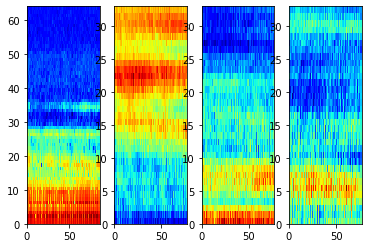

In [9]:
DataSet_ALS = ALSDataset(dir_HC, dir_ALS)
# print(len(DataSet_ALS))
X_generic, y_label = DataSet_ALS.__getitem__(13202)

fig,ax = plt.subplots()
plt.subplot(141)
plt.pcolor(X_generic[0,:,:], cmap='jet')
print('label = ', y_label)
fold_0_train,fold_0_val,fold_0_test = DataSet_ALS.get_kth_fold_inds(0)

## NN
conv_lf = torch.nn.Conv2d(1,3,(32,10),padding='valid',dtype=torch.float)

input = torch.tensor(X_generic,dtype=torch.float)
output = conv_lf(input)
output_np = output.detach().numpy()
plt.subplot(142)
plt.pcolor(output_np[0,:,:], cmap='jet')
plt.subplot(143)
plt.pcolor(output_np[1,:,:], cmap='jet')
plt.subplot(144)
plt.pcolor(output_np[2,:,:], cmap='jet')

#### ALS_CNN (CNN-model)

In [64]:
class ALS_CNN(nn.Module):
    def __init__(self):
        super(ALS_CNN,self).__init__() 
        # parameters
        # file = open("drive/MyDrive/Colab Notebooks/config.json")
        file = open("config.json")
        config = json.load(file)            
        self.n_mel = config['data']['n_mel_channels']
        frames_in_segment = config['data']['supra_frame_length']
        layer1_filt = 64
        layer2_filt = 32
        
        self.lf_num = 32    # low-frequency
        self.mf_num = 16    # medium-frequency
        self.hf_num = 16    # high-frequency
        
        lf_width,  mf_width,  hf_width  = 48,36,24    # low/medium/high-frequency time span
        lf_height, mf_height, hf_height = 16,8,8      # low/medium/high-frequency frequency span

        l2_kernel_size = 7

        lf_h_stride, mf_h_stride, hf_h_stride = 2,1,1
        lf_w_stride, mf_w_stride, hf_w_stride = 4, 4, 4

        self.batch_norm1 = nn.BatchNorm2d(1)
        
        # self.conv_lf = torch.nn.Conv2d(1,self.layer1_filt,(self.lf_num, lf_width),padding='valid',stride=(1,lf_width//2))
        # self.conv_mf = torch.nn.Conv2d(1,self.layer1_filt,(self.mf_num, mf_width),padding='valid',stride=(1,mf_width//2))
        # self.conv_hf = torch.nn.Conv2d(1,self.layer1_filt,(self.hf_num, hf_width),padding='valid',stride=(1,hf_width//2))

        self.conv_lf = torch.nn.Conv2d(1,layer1_filt,(lf_height, lf_width),padding='valid',stride=(lf_h_stride,lf_w_stride))
        self.conv_mf = torch.nn.Conv2d(1,layer1_filt,(mf_height, mf_width),padding='valid',stride=(mf_h_stride,mf_w_stride))
        self.conv_hf = torch.nn.Conv2d(1,layer1_filt,(hf_height, hf_width),padding='valid',stride=(hf_h_stride,hf_w_stride))

        self.conv2_lf = torch.nn.Conv2d(layer1_filt, layer2_filt,l2_kernel_size,padding='valid',stride=(1,1))
        self.conv2_mf = torch.nn.Conv2d(layer1_filt, layer2_filt,l2_kernel_size,padding='valid',stride=(1,1))
        self.conv2_hf = torch.nn.Conv2d(layer1_filt, layer2_filt,l2_kernel_size,padding='valid',stride=(1,1))

        self.maxpool_lf = nn.MaxPool2d(((self.lf_num - lf_height)//lf_h_stride + 1 - (l2_kernel_size-1),1))
        self.maxpool_mf = nn.MaxPool2d(((self.mf_num - mf_height)//mf_h_stride + 1 - (l2_kernel_size-1),1))
        self.maxpool_hf = nn.MaxPool2d(((self.hf_num - hf_height)//hf_h_stride + 1 - (l2_kernel_size-1),1))

        self.drop1 = nn.Dropout(p=0.1)
        
        self.fc = nn.Linear(layer2_filt*(1+((frames_in_segment-lf_width)//lf_w_stride) - (l2_kernel_size-1)) + # *(1+(self.lf_num-lf_height)//lf_height)
                            layer2_filt*(1+((frames_in_segment-mf_width)//mf_w_stride) - (l2_kernel_size-1)) + #*(1+(self.mf_num-mf_height)//mf_height) + 
                            layer2_filt*(1+((frames_in_segment-hf_width)//hf_w_stride) - (l2_kernel_size-1)) #*(1+(self.hf_num-hf_height)//hf_height)
                            ,1)    # 16 = np.round(()/5).astype(int)                                  

        torch.manual_seed(151)
        # nn.init.xavier_uniform_(self.conv_lf.weight, gain=1.0)
        # nn.init.xavier_uniform_(self.conv_mf.weight, gain=1.0)
        # nn.init.xavier_uniform_(self.conv_hf.weight, gain=1.0)
        
        nn.init.kaiming_normal_(self.conv_lf.weight)
        nn.init.kaiming_normal_(self.conv_mf.weight)
        nn.init.kaiming_normal_(self.conv_hf.weight)

        nn.init.kaiming_normal_(self.conv2_lf.weight)
        nn.init.kaiming_normal_(self.conv2_mf.weight)
        nn.init.kaiming_normal_(self.conv2_hf.weight)

        nn.init.xavier_normal_(self.fc.weight)
    
    def forward(self, x): 
        
        out = self.batch_norm1(x)

        out1 = out[:,:,:self.lf_num,:]
        out2 = out[:,:,self.lf_num:self.lf_num+self.mf_num,:]
        out3 = out[:,:,self.lf_num+self.mf_num:self.lf_num+self.mf_num+self.hf_num,:]

        out1 = torch.relu(self.conv_lf(out1))
        out2 = torch.relu(self.conv_mf(out2))
        out3 = torch.relu(self.conv_hf(out3))
        
        out1 = torch.relu(self.conv2_lf(out1))
        out2 = torch.relu(self.conv2_mf(out2))
        out3 = torch.relu(self.conv2_hf(out3))

        out1 = self.maxpool_lf(out1)        
        out2 = self.maxpool_mf(out2)
        out3 = self.maxpool_hf(out3)

        out1 = out1.view(-1, out1.shape[1]*out1.shape[2]*out1.shape[3])
        out2 = out2.view(-1, out2.shape[1]*out2.shape[2]*out2.shape[3])
        out3 = out3.view(-1, out3.shape[1]*out3.shape[2]*out3.shape[3])

        # print('After view 1:', out1.shape)

        out = torch.cat((out1,out2,out3), 1)  

        # print('After cat:', out.shape)

        out = self.drop1(out)

        out = self.fc(out)
        return out   

# one-layer conv-3freq_band->maxpool-fc
# class ALS_CNN(nn.Module):
#     def __init__(self):
#         super(ALS_CNN,self).__init__() 
#         # parameters
#         file = open("drive/MyDrive/Colab Notebooks/config.json")
#         config = json.load(file)            
#         self.n_mel = config['data']['n_mel_channels']
#         frames_in_segment = config['data']['supra_frame_length']
#         self.layer1_filt = 64
        
#         self.lf_num = 32    # low-frequency
#         self.mf_num = 16    # medium-frequency
#         self.hf_num = 16    # high-frequency
        
#         lf_width,  mf_width,  hf_width  = 48,36,24      # low/medium/high-frequency time span
#         lf_height, mf_height, hf_height = 16,8,8      # low/medium/high-frequency frequency span

#         lf_h_stride, mf_h_stride, hf_h_stride = 8,4,2
#         lf_w_stride, mf_w_stride, hf_w_stride = lf_width//2, mf_width//2, hf_width//2

#         self.batch_norm1 = nn.BatchNorm2d(1)
        
#         # self.conv_lf = torch.nn.Conv2d(1,self.layer1_filt,(self.lf_num, lf_width),padding='valid',stride=(1,lf_width//2))
#         # self.conv_mf = torch.nn.Conv2d(1,self.layer1_filt,(self.mf_num, mf_width),padding='valid',stride=(1,mf_width//2))
#         # self.conv_hf = torch.nn.Conv2d(1,self.layer1_filt,(self.hf_num, hf_width),padding='valid',stride=(1,hf_width//2))

#         self.conv_lf = torch.nn.Conv2d(1,self.layer1_filt,(lf_height, lf_width),padding='valid',stride=(lf_h_stride,lf_w_stride))
#         self.conv_mf = torch.nn.Conv2d(1,self.layer1_filt,(mf_height, mf_width),padding='valid',stride=(mf_h_stride,mf_w_stride))
#         self.conv_hf = torch.nn.Conv2d(1,self.layer1_filt,(hf_height, hf_width),padding='valid',stride=(hf_h_stride,hf_w_stride))

#         self.maxpool_lf = nn.MaxPool2d(((self.lf_num - lf_height)//lf_h_stride + 1,1))
#         self.maxpool_mf = nn.MaxPool2d(((self.mf_num - mf_height)//mf_h_stride + 1,1))
#         self.maxpool_hf = nn.MaxPool2d(((self.hf_num - hf_height)//hf_h_stride + 1,1))

#         self.drop1 = nn.Dropout(p=0.5)
        
#         self.fc = nn.Linear(self.layer1_filt*(1+(frames_in_segment-lf_width)//lf_w_stride) + # *(1+(self.lf_num-lf_height)//lf_height)
#                             self.layer1_filt*(1+(frames_in_segment-mf_width)//mf_w_stride) + #*(1+(self.mf_num-mf_height)//mf_height) + 
#                             self.layer1_filt*(1+(frames_in_segment-hf_width)//hf_w_stride) #*(1+(self.hf_num-hf_height)//hf_height)
#                             ,1)    # 16 = np.round(()/5).astype(int)                                  

#         torch.manual_seed(151)
#         nn.init.xavier_uniform_(self.conv_lf.weight, gain=1.0)
#         nn.init.xavier_uniform_(self.conv_mf.weight, gain=1.0)
#         nn.init.xavier_uniform_(self.conv_hf.weight, gain=1.0)
    
#     def forward(self, x): 
        
#         out = self.batch_norm1(x)

#         out1 = out[:,:,:self.lf_num,:]
#         out2 = out[:,:,self.lf_num:self.lf_num+self.mf_num,:]
#         out3 = out[:,:,self.lf_num+self.mf_num:self.lf_num+self.mf_num+self.hf_num,:]
        
#         # print(x.shape)
#         # print(x1.shape)
#         # for param in self.conv_lf.parameters():
#         #     print(param.data)
#         #     print(param.data.shape)
#         # print(self.conv_lf.weight())
#         # print(x2.shape)
#         # print(x3.shape)
        
#         out1 = self.conv_lf(out1)
#         out2 = self.conv_mf(out2)
#         out3 = self.conv_hf(out3)
                
#         # print(out2.shape)
#         # print(out3.shape)

#         out1 = torch.relu(out1)
#         out2 = torch.relu(out2)
#         out3 = torch.relu(out3)
        
#         out1 = self.maxpool_lf(out1)        
#         out2 = self.maxpool_mf(out2)
#         out3 = self.maxpool_hf(out3)

#         out1 = out1.view(-1, out1.shape[1]*out1.shape[2]*out1.shape[3])
#         out2 = out2.view(-1, out2.shape[1]*out2.shape[2]*out2.shape[3])
#         out3 = out3.view(-1, out3.shape[1]*out3.shape[2]*out3.shape[3])

#         # print('After view 1:', out1.shape)

#         out = torch.cat((out1,out2,out3), 1).cuda()  

#         # print('After cat:', out.shape)

#         out = self.drop1(out)

#         out = self.fc(out)
#         return out    

#### Time CNN

In [33]:
class time_CNN(nn.Module):
    def __init__(self):
        super(time_CNN,self).__init__() 
        # parameters
        # file = open("drive/MyDrive/Colab Notebooks/config.json")
        file = open("config.json")
        config = json.load(file)            
        n_mel = config['data']['n_mel_channels']
        frames_in_segment = config['data']['supra_frame_length']
        
        layer_filt = [64,64,64]
        layer_kernel_size = [(1,6), (1,5), (1,3)]
        layer_max_pool_size = [(1,2),(1,3),(1,3)]

        self.batch_norm1 = nn.BatchNorm2d(1)

        self.conv1 = torch.nn.Conv2d(1,layer_filt[0], layer_kernel_size[0], padding='same', stride=(1,1))
        self.conv2 = torch.nn.Conv2d(layer_filt[0],layer_filt[1], layer_kernel_size[1], padding='same', stride=(1,1))
        self.conv3 = torch.nn.Conv2d(layer_filt[1],layer_filt[2], layer_kernel_size[2], padding='same', stride=(1,1))

        self.maxpool_1 = nn.MaxPool2d(layer_max_pool_size[0],stride=layer_max_pool_size[0])
        self.maxpool_2 = nn.MaxPool2d(layer_max_pool_size[1],stride=layer_max_pool_size[1])
        self.maxpool_3 = nn.MaxPool2d(layer_max_pool_size[2],stride=layer_max_pool_size[2])
        
        self.drop1 = nn.Dropout(p=0.05)

        self.fc1 = nn.Linear(16384,1)

        torch.manual_seed(151)
        nn.init.kaiming_normal_(self.conv1.weight)
        nn.init.kaiming_normal_(self.conv2.weight)
        nn.init.kaiming_normal_(self.conv3.weight)
        nn.init.xavier_normal_(self.fc1.weight)
    
    def forward(self, x): 
        
        out = self.batch_norm1(x)

        out = torch.relu(self.conv1(out))        
        out = self.maxpool_1(out)

        out = torch.relu(self.conv2(out))
        out = self.maxpool_2(out)

        out = torch.relu(self.conv3(out))
        out = self.maxpool_3(out)

        out = out.view(-1, out.shape[1]*out.shape[2]*out.shape[3])

        out = self.drop1(out)

        out = self.fc1(out)

        return out

#### training_loop

In [53]:
def training_loop(n_epochs, optimizer, lr_scheduler, model, loss_fn, train_loader, val_loader):    
    MODEL_PATH = "model_backup/model_cnn.pt"
    loss_train_history = np.ndarray((n_epochs))
    loss_val_history = np.ndarray((n_epochs))
    lrs = []
    for epoch in range(1,n_epochs+1):        
        model.train()
        best_acc = 0
        loss_val_best = 0
        loss_train = 0.0
        for specs, labels in tqdm(train_loader, desc=f"Epoch {epoch}", leave=True): #train_loader:
            specs = specs.float()
            outputs = model(specs)                        
            outputs = outputs.squeeze(dim=1) # for batch train_loader 
            # print('output:',outputs)
            # print('labels:',labels)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()            
        
        # prediction on val set        
        loss_val = 0.0
        TP_TN_sum = 0
        item_num = 0
        model.eval()
        with torch.no_grad():            
            for spec, label in val_loader:
                spec = spec.float()                    
                pred = model(spec)                                
                pred = torch.squeeze(pred,1)                

                loss = loss_fn(pred, label)
                loss_val += loss.item()
                
                item_num += len(label)

                pred = (pred>0)*1.0
                TP_TN_sum = TP_TN_sum + torch.sum(label==pred)

        acc_val = TP_TN_sum/item_num
        
        loss_train_history[epoch-1] = loss_train / len(train_loader)
        loss_val_history[epoch-1] = loss_val / len(val_loader)

        if acc_val>best_acc:
            torch.save(model.state_dict(), MODEL_PATH)            
            loss_val_best = loss_val
        elif acc_val==best_acc:
            if loss_val > loss_val_best:
                torch.save(model.state_dict(), MODEL_PATH)            
                loss_val_best = loss_val

        # if epoch==1 or epoch%2==0:                                                            
        print(f'{datetime.datetime.now()} Epoch {epoch}, Train loss {loss_train / len(train_loader):.3f}, Val loss {loss_val / len(val_loader):.3f}, Acc_val = {acc_val:.2f}')
        
        lrs.append(optimizer.param_groups[0]["lr"])
        lr_scheduler.step()
        
    # model = torch.load(MODEL_PATH)
    model.load_state_dict(torch.load(MODEL_PATH))

    fig, ax = plt.subplots(figsize=(6,2.5))
    plt.rcParams.update({'font.size': 12})
    # plt.subplot(1,2,1)
    plt.plot(range(n_epochs), loss_train_history, label='Обучающий набор')
    plt.plot(range(n_epochs), loss_val_history, label='Проверочный набор')
    plt.legend()
    plt.xlabel('Эпоха')
    plt.ylabel('Ошибка обучения')
    # plt.subplot(1,2,2)
    # plt.plot(range(len(lrs)),lrs)
    # plt.xlabel('step')
    # plt.ylabel('lr')    
    plt.show()
    # Saving results
    # image_name = f'figures/loss_NN.jpg'
    # fig.savefig(image_name, format='jpg', dpi=110, bbox_inches='tight', pad_inches = 0.2)
    return (loss_train_history,loss_val_history)

    
# def training_loop(n_epochs, optimizer, lr_scheduler, model, loss_fn, train_loader, val_loader):    
#     MODEL_PATH = "model_backup/model_cnn.pt"
#     loss_train_history = np.ndarray((n_epochs))
#     loss_val_history = np.ndarray((n_epochs))
#     lrs = []
#     for epoch in range(1,n_epochs+1):        
#         model.train()
#         best_acc = 0
#         loss_train = 0.0
#         for specs, labels in tqdm(train_loader, desc=f"Epoch {epoch}", leave=True): #train_loader:
#             specs = specs.float()
#             outputs = model(specs)                        
#             outputs = outputs.squeeze(dim=1) # for batch train_loader 
#             # print('output:',outputs)
#             # print('labels:',labels)
#             loss = loss_fn(outputs, labels)
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
#             loss_train += loss.item()            
        
#         # prediction on val set        
#         loss_val = 0.0
#         TP_TN_sum = 0
#         item_num = 0
#         model.eval()
#         with torch.no_grad():            
#             for spec, label in val_loader:
#                 spec = spec.float()                    
#                 pred = model(spec)                                
#                 pred = torch.squeeze(pred,1)                

#                 loss = loss_fn(pred, label)
#                 loss_val += loss.item()
                
#                 item_num += len(label)

#                 pred = (pred>0)*1.0
#                 TP_TN_sum = TP_TN_sum + torch.sum(label==pred)

#         acc_val = TP_TN_sum/item_num
        
#         loss_train_history[epoch-1] = loss_train / len(train_loader)
#         loss_val_history[epoch-1] = loss_val / len(val_loader)

#         if acc_val>=best_acc:
#             torch.save(model.state_dict(), MODEL_PATH)            
#             # torch.save(model, MODEL_PATH)

#         # if epoch==1 or epoch%2==0:                                                            
#         print(f'{datetime.datetime.now()} Epoch {epoch}, Train loss {loss_train / len(train_loader):.3f}, Val loss {loss_val / len(val_loader):.3f}, Acc_val = {acc_val:.2f}')
        
#         lrs.append(optimizer.param_groups[0]["lr"])
#         lr_scheduler.step()
        
#     # model = torch.load(MODEL_PATH)
#     model.load_state_dict(torch.load(MODEL_PATH))

#     fig, ax = plt.subplots(figsize=(8,3))
#     plt.rcParams.update({'font.size': 13})
#     # plt.subplot(1,2,1)
#     plt.plot(range(n_epochs), loss_train_history, label='Обучающий набор')
#     plt.plot(range(n_epochs), loss_val_history, label='Проверочный набор')
#     plt.legend()
#     plt.xlabel('Эпоха')
#     plt.ylabel('Ошибка обучения')
#     # plt.subplot(1,2,2)
#     # plt.plot(range(len(lrs)),lrs)
#     # plt.xlabel('step')
#     # plt.ylabel('lr')    
#     plt.show()
#     # Saving results
#     # image_name = f'figures/loss_NN.jpg'
#     # fig.savefig(image_name, format='jpg', dpi=110, bbox_inches='tight', pad_inches = 0.2)

### Single NN training & evaluation

In [ ]:
# Test inference
model = ALS_CNN()
X, y = DataSet_ALS.__getitem__(13202)
input = torch.tensor(X, dtype=torch.float)
input = input.unsqueeze(0)  # add chanel dimension
input = input.unsqueeze(0)  # add batch dimension
print(input.shape)
y_out = model(input)

torch.Size([1, 1, 64, 86])


In [ ]:
fold_0_train_inds,fold_0_val_inds,fold_0_test_inds = DataSet_ALS.get_kth_fold_inds(0)
train_set = torch.utils.data.dataset.Subset(DataSet_ALS, fold_0_train_inds)
val_set = torch.utils.data.dataset.Subset(DataSet_ALS, fold_0_val_inds)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=100, shuffle=True) # num_workers=1
val_loader = torch.utils.data.DataLoader(val_set, batch_size=10, shuffle=False,) # num_workers=1

model = ALS_CNN().to(device)
model.train()

# summary(ALS_cnn,(64*86))
# optimizer = optim.SGD(ALS_cnn.parameters(), lr=1e-3, momentum=0.10)
optimizer = optim.Adam(model.parameters(),lr=2e-5, weight_decay=2e-1)

# loss_fn = nn.CrossEntropyLoss()
# pos_weight = torch.ones([1])
# loss_fn = nn.BCEWithLogitsLoss(pos_weight = pos_weight)

loss_fn = nn.BCEWithLogitsLoss()
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

training_loop(
    n_epochs=20,
    optimizer=optimizer,
    lr_scheduler = scheduler,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
    val_loader = val_loader
)

### Train with 5-fold CV

#### crossvalid

In [ ]:
def crossvalid(dataset=None, model = None, train = None, optimizer = None, n_epochs = 20, k_fold=5):    
    
    total_size = len(dataset)
    y_pred = np.ndarray(total_size)
    y_true = np.ndarray(total_size)
    folds = list([4,3,2,1,0])

    for i in folds: #range(k_fold):
        
        inds_train,inds_val,inds_test = dataset.get_kth_fold_inds(i)                
        
        train_set = torch.utils.data.dataset.Subset(dataset,inds_train)
        val_set = torch.utils.data.dataset.Subset(dataset,inds_val)
        test_set = torch.utils.data.dataset.Subset(dataset,inds_test)
                
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=100,shuffle=True)  # num_workers=2
        val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=False)
        test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False)    # num_workers=2
        
        torch.manual_seed(707)
        with torch.no_grad():
            for layer in model.children():
                if hasattr(layer, 'reset_parameters'):
                    # print(layer.weight())
                    layer.reset_parameters()
                    # print(layer.weight())
        
        model.train()        

        loss_fn = nn.BCEWithLogitsLoss()
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

        train(
            n_epochs=n_epochs,
            optimizer=optimizer,
            lr_scheduler = scheduler,
            model=model,
            loss_fn=loss_fn,
            train_loader=train_loader,
            val_loader=val_loader
        )

        # prediction on test set        
        test_score = list()
        TP_TN_sum = 0
        model.eval()
        with torch.no_grad():
            i = 0
            for spec, label in test_loader:
                spec = spec.float()
                # spec = spec.squeeze()
                pred = model(spec)
                pred = torch.squeeze(pred,1)  
                test_score.append(pred.numpy())
                if pred>0:
                    pred = torch.tensor(1, dtype=torch.float64)
                    y_pred[inds_test[i]] = 1
                else:
                    pred = torch.tensor(0, dtype=torch.float64)                
                    y_pred[inds_test[i]] = 0
                y_true[inds_test[i]] = label
                if pred==label:
                    TP_TN_sum +=1                
                i +=1                 
            print('Acc = ', TP_TN_sum/len(test_score))

    acc_sk = metrics.accuracy_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    prec = metrics.precision_score(y_true, y_pred)
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    sensetivity = tp / (tp+fn)
    specificity = tn / (tn+fp)
    print('Final results')
    print(f'Acc_sk = {acc_sk:.2f}', )
    print(f'Prec = {prec:.2f}')
    print(f'Recall = {recall:.2f}')
    print(f'Sens = {sensetivity:.2f}')
    print(f'Spec = {specificity:.2f}')

        # val_acc = valid(res_model,criterion,optimizer,val_loader)
        # val_score.at[i] = val_acc
    
    return acc_sk
        
# https://stackoverflow.com/questions/60883696/k-fold-cross-validation-using-dataloaders-in-pytorch

#### k_fold_CV

In [58]:
def k_fold_CV(dataset=None, model = None, train = None, optimizer = None, n_epochs = 20, k_fold=5):    
    
    total_size = len(dataset)
    y_pred = np.ndarray(total_size)
    y_true = np.ndarray(total_size)
    folds = list([4,3,2,1,0])

    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

    PATH = 'model_backup' + os.sep + 'cnn_init.pt'
    PATH_optim = 'model_backup'+os.sep+'cnn_optim_init.pt'
    PATH_lr = 'model_backup' + os.sep + 'cnn_lr_schedule_init.pt'

    torch.save(model.state_dict(), PATH)
    torch.save(optimizer.state_dict(), PATH_optim)
    torch.save(scheduler.state_dict(), PATH_lr)

    loss_train_history_list = list()
    loss_val_history_list = list()
    fold_acc = list()
    for i in folds: #range(k_fold):
        
        inds_train,inds_val,inds_test = dataset.get_kth_fold_inds(i)                
        
        train_set = torch.utils.data.dataset.Subset(dataset,inds_train)
        val_set = torch.utils.data.dataset.Subset(dataset,inds_val)
        test_set = torch.utils.data.dataset.Subset(dataset,inds_test)
                
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=100,shuffle=True)  # num_workers=2
        val_loader = torch.utils.data.DataLoader(val_set, batch_size=100, shuffle=False)
        test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False)    # num_workers=2
        
        model.load_state_dict(torch.load(PATH))
        optimizer.load_state_dict(torch.load(PATH_optim))
        scheduler.load_state_dict(torch.load(PATH_lr))

        model.train()        

        loss_fn = nn.BCEWithLogitsLoss()        

        loss_train_history, loss_val_history = train(
            n_epochs=n_epochs,
            optimizer=optimizer,
            lr_scheduler = scheduler,
            model=model,
            loss_fn=loss_fn,
            train_loader=train_loader,
            val_loader=val_loader
        )

        loss_train_history_list.append(loss_train_history)
        loss_val_history_list.append(loss_val_history)

        # prediction on test set        
        test_score = list()
        TP_TN_sum = 0
        model.eval()
        with torch.no_grad():
            i = 0
            for spec, label in test_loader:
                spec = spec.float()
                # spec = spec.squeeze()
                pred = model(spec)
                pred = torch.squeeze(pred,1)  
                # test_score.append(pred.numpy())
                test_score.append(pred)
                if pred>0:
                    pred = torch.tensor(1, dtype=torch.float64)
                    y_pred[inds_test[i]] = 1
                else:
                    pred = torch.tensor(0, dtype=torch.float64)                
                    y_pred[inds_test[i]] = 0                    
                y_true[inds_test[i]] = label

                if pred==label:
                    TP_TN_sum +=1                
                i +=1
            fold_acc.append(TP_TN_sum/len(test_score))
            print('Acc = ', TP_TN_sum/len(test_score))

    fig, ax = plt.subplots(figsize=(12,2.5))
    plt.rcParams.update({'font.size': 10})    

    for i in folds:
        plt.subplot(1,len(folds),i+1)
        plt.plot(range(n_epochs), loss_train_history_list[i], label='Обучающий набор')
        plt.plot(range(n_epochs), loss_val_history_list[i], label='Проверочный набор')
        plt.legend()
        plt.xlabel('Эпоха')
        plt.ylabel('Ошибка обучения')
    

    acc_sk = metrics.accuracy_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    prec = metrics.precision_score(y_true, y_pred)
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    sensetivity = tp / (tp+fn)
    specificity = tn / (tn+fp)
    
    print('Final results')
    print(f'{n_epochs} epoch. Acc_sk = {acc_sk:.2f} (Sens = {sensetivity:.2f} / Spec = {specificity:.2f}) {fold_acc[0]:.2f} / {fold_acc[1]:.2f} / {fold_acc[2]:.2f} / {fold_acc[3]:.2f} / {fold_acc[4]:.2f}')  
    
    # return acc_sk

#### Start script

In [ ]:
# script with reset.parameters()
dir_HC = 'drive/MyDrive/Colab Notebooks/wav'+ os.sep + 'HC' + os.sep
dir_ALS = 'drive/MyDrive/Colab Notebooks/wav' + os.sep + 'ALS' + os.sep

DataSet_ALS = ALSDataset(dir_HC, dir_ALS)
model = ALS_CNN()

# optimizer = optim.SGD(ALS_cnn.parameters(), lr=1e-3, momentum=0.10)
optimizer = optim.Adam(model.parameters(),lr=1e-3, weight_decay=2e-3) # weight_decay is L2 regularization

crossvalid(dataset=DataSet_ALS, model = model, train = training_loop, optimizer = optimizer, n_epochs=15, k_fold=5)

#### Start k-fold CV

Epoch 1: 100%|██████████| 125/125 [00:32<00:00,  3.88it/s]


2023-05-26 20:02:50.147161 Epoch 1, Train loss 0.476, Val loss 0.420, Acc_val = 0.89


Epoch 2: 100%|██████████| 125/125 [00:32<00:00,  3.87it/s]


2023-05-26 20:03:23.494073 Epoch 2, Train loss 0.226, Val loss 0.443, Acc_val = 0.85


Epoch 3: 100%|██████████| 125/125 [00:31<00:00,  3.95it/s]


2023-05-26 20:03:56.205053 Epoch 3, Train loss 0.157, Val loss 0.595, Acc_val = 0.86


Epoch 4: 100%|██████████| 125/125 [00:32<00:00,  3.90it/s]


2023-05-26 20:04:29.278006 Epoch 4, Train loss 0.121, Val loss 0.601, Acc_val = 0.69


Epoch 5: 100%|██████████| 125/125 [00:31<00:00,  3.91it/s]


2023-05-26 20:05:02.349868 Epoch 5, Train loss 0.110, Val loss 0.629, Acc_val = 0.81


Epoch 6: 100%|██████████| 125/125 [00:32<00:00,  3.88it/s]


2023-05-26 20:05:35.646948 Epoch 6, Train loss 0.094, Val loss 0.605, Acc_val = 0.83


Epoch 7: 100%|██████████| 125/125 [00:32<00:00,  3.83it/s]


2023-05-26 20:06:09.415599 Epoch 7, Train loss 0.089, Val loss 0.617, Acc_val = 0.69


Epoch 8: 100%|██████████| 125/125 [00:35<00:00,  3.52it/s]


2023-05-26 20:06:45.959881 Epoch 8, Train loss 0.085, Val loss 0.589, Acc_val = 0.68


Epoch 9: 100%|██████████| 125/125 [00:38<00:00,  3.27it/s]


2023-05-26 20:07:25.145661 Epoch 9, Train loss 0.089, Val loss 0.591, Acc_val = 0.81


Epoch 10: 100%|██████████| 125/125 [00:38<00:00,  3.26it/s]


2023-05-26 20:08:04.719844 Epoch 10, Train loss 0.085, Val loss 0.595, Acc_val = 0.85


Epoch 11: 100%|██████████| 125/125 [00:44<00:00,  2.79it/s]


2023-05-26 20:08:52.386153 Epoch 11, Train loss 0.082, Val loss 0.884, Acc_val = 0.65


Epoch 12: 100%|██████████| 125/125 [00:54<00:00,  2.30it/s]


2023-05-26 20:09:50.159432 Epoch 12, Train loss 0.077, Val loss 0.711, Acc_val = 0.71


Epoch 13: 100%|██████████| 125/125 [00:49<00:00,  2.51it/s]


2023-05-26 20:10:42.801809 Epoch 13, Train loss 0.079, Val loss 0.902, Acc_val = 0.59


Epoch 14: 100%|██████████| 125/125 [00:52<00:00,  2.38it/s]


2023-05-26 20:11:39.457535 Epoch 14, Train loss 0.081, Val loss 0.888, Acc_val = 0.66


Epoch 15: 100%|██████████| 125/125 [00:57<00:00,  2.19it/s]


2023-05-26 20:12:40.613252 Epoch 15, Train loss 0.079, Val loss 0.964, Acc_val = 0.52


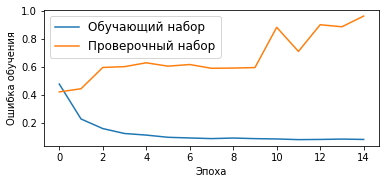

Acc =  0.559508895013781


Epoch 1: 100%|██████████| 132/132 [00:31<00:00,  4.14it/s]


2023-05-26 20:13:27.016788 Epoch 1, Train loss 0.420, Val loss 0.507, Acc_val = 0.68


Epoch 2: 100%|██████████| 132/132 [00:34<00:00,  3.77it/s]


2023-05-26 20:14:02.536196 Epoch 2, Train loss 0.152, Val loss 1.064, Acc_val = 0.46


Epoch 3: 100%|██████████| 132/132 [00:31<00:00,  4.18it/s]


2023-05-26 20:14:34.725746 Epoch 3, Train loss 0.118, Val loss 1.393, Acc_val = 0.51


Epoch 4: 100%|██████████| 132/132 [00:33<00:00,  3.98it/s]


2023-05-26 20:15:08.445836 Epoch 4, Train loss 0.102, Val loss 0.581, Acc_val = 0.70


Epoch 5: 100%|██████████| 132/132 [00:31<00:00,  4.20it/s]


2023-05-26 20:15:40.439581 Epoch 5, Train loss 0.096, Val loss 1.498, Acc_val = 0.51


Epoch 6: 100%|██████████| 132/132 [00:31<00:00,  4.22it/s]


2023-05-26 20:16:12.292217 Epoch 6, Train loss 0.086, Val loss 1.216, Acc_val = 0.55


Epoch 7: 100%|██████████| 132/132 [00:30<00:00,  4.26it/s]


2023-05-26 20:16:43.820035 Epoch 7, Train loss 0.083, Val loss 1.115, Acc_val = 0.56


Epoch 8: 100%|██████████| 132/132 [00:34<00:00,  3.84it/s]


2023-05-26 20:17:18.772952 Epoch 8, Train loss 0.083, Val loss 1.505, Acc_val = 0.55


Epoch 9: 100%|██████████| 132/132 [00:34<00:00,  3.85it/s]


2023-05-26 20:17:53.529237 Epoch 9, Train loss 0.085, Val loss 2.052, Acc_val = 0.38


Epoch 10: 100%|██████████| 132/132 [00:36<00:00,  3.62it/s]


2023-05-26 20:18:30.714629 Epoch 10, Train loss 0.081, Val loss 1.078, Acc_val = 0.48


Epoch 11: 100%|██████████| 132/132 [00:41<00:00,  3.15it/s]


2023-05-26 20:19:13.456896 Epoch 11, Train loss 0.089, Val loss 0.817, Acc_val = 0.56


Epoch 12: 100%|██████████| 132/132 [00:43<00:00,  3.03it/s]


2023-05-26 20:19:57.751556 Epoch 12, Train loss 0.088, Val loss 1.361, Acc_val = 0.55


Epoch 13: 100%|██████████| 132/132 [00:41<00:00,  3.17it/s]


2023-05-26 20:20:40.631474 Epoch 13, Train loss 0.076, Val loss 2.597, Acc_val = 0.38


Epoch 14: 100%|██████████| 132/132 [00:47<00:00,  2.81it/s]


2023-05-26 20:21:29.526045 Epoch 14, Train loss 0.080, Val loss 1.785, Acc_val = 0.51


Epoch 15: 100%|██████████| 132/132 [00:53<00:00,  2.48it/s]


2023-05-26 20:22:24.989768 Epoch 15, Train loss 0.075, Val loss 1.496, Acc_val = 0.56


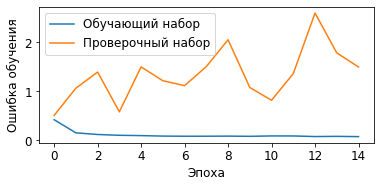

Acc =  0.7825573150555424


Epoch 1: 100%|██████████| 127/127 [00:31<00:00,  4.08it/s]


2023-05-26 20:23:16.401219 Epoch 1, Train loss 0.414, Val loss 0.586, Acc_val = 0.70


Epoch 2: 100%|██████████| 127/127 [00:30<00:00,  4.18it/s]


2023-05-26 20:23:47.533275 Epoch 2, Train loss 0.191, Val loss 0.539, Acc_val = 0.80


Epoch 3: 100%|██████████| 127/127 [00:30<00:00,  4.19it/s]


2023-05-26 20:24:18.538894 Epoch 3, Train loss 0.130, Val loss 0.660, Acc_val = 0.77


Epoch 4: 100%|██████████| 127/127 [00:29<00:00,  4.25it/s]


2023-05-26 20:24:49.149474 Epoch 4, Train loss 0.105, Val loss 0.678, Acc_val = 0.75


Epoch 5: 100%|██████████| 127/127 [00:29<00:00,  4.26it/s]


2023-05-26 20:25:19.653074 Epoch 5, Train loss 0.094, Val loss 0.633, Acc_val = 0.85


Epoch 6: 100%|██████████| 127/127 [00:31<00:00,  4.06it/s]


2023-05-26 20:25:51.677488 Epoch 6, Train loss 0.088, Val loss 0.541, Acc_val = 0.81


Epoch 7: 100%|██████████| 127/127 [00:30<00:00,  4.19it/s]


2023-05-26 20:26:22.685007 Epoch 7, Train loss 0.079, Val loss 0.615, Acc_val = 0.70


Epoch 8: 100%|██████████| 127/127 [00:31<00:00,  4.07it/s]


2023-05-26 20:26:54.568275 Epoch 8, Train loss 0.079, Val loss 1.127, Acc_val = 0.64


Epoch 9: 100%|██████████| 127/127 [00:33<00:00,  3.79it/s]


2023-05-26 20:27:28.847381 Epoch 9, Train loss 0.075, Val loss 0.515, Acc_val = 0.80


Epoch 10: 100%|██████████| 127/127 [00:33<00:00,  3.82it/s]


2023-05-26 20:28:02.935062 Epoch 10, Train loss 0.091, Val loss 0.506, Acc_val = 0.85


Epoch 11: 100%|██████████| 127/127 [00:35<00:00,  3.56it/s]


2023-05-26 20:28:40.317371 Epoch 11, Train loss 0.073, Val loss 0.882, Acc_val = 0.67


Epoch 12: 100%|██████████| 127/127 [00:41<00:00,  3.09it/s]


2023-05-26 20:29:22.530557 Epoch 12, Train loss 0.071, Val loss 0.567, Acc_val = 0.78


Epoch 13: 100%|██████████| 127/127 [00:39<00:00,  3.23it/s]


2023-05-26 20:30:03.129215 Epoch 13, Train loss 0.070, Val loss 0.707, Acc_val = 0.74


Epoch 14: 100%|██████████| 127/127 [00:42<00:00,  2.97it/s]


2023-05-26 20:30:46.920461 Epoch 14, Train loss 0.067, Val loss 0.616, Acc_val = 0.78


Epoch 15: 100%|██████████| 127/127 [00:42<00:00,  2.97it/s]


2023-05-26 20:31:31.218062 Epoch 15, Train loss 0.076, Val loss 0.669, Acc_val = 0.77


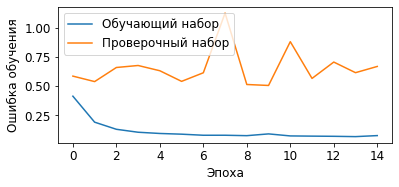

Acc =  0.7136279926335175


Epoch 1: 100%|██████████| 137/137 [00:32<00:00,  4.24it/s]


2023-05-26 20:32:17.412295 Epoch 1, Train loss 0.426, Val loss 0.196, Acc_val = 1.00


Epoch 2: 100%|██████████| 137/137 [00:33<00:00,  4.13it/s]


2023-05-26 20:32:51.217034 Epoch 2, Train loss 0.146, Val loss 0.086, Acc_val = 1.00


Epoch 3: 100%|██████████| 137/137 [00:32<00:00,  4.20it/s]


2023-05-26 20:33:24.453283 Epoch 3, Train loss 0.109, Val loss 0.132, Acc_val = 0.96


Epoch 4: 100%|██████████| 137/137 [00:33<00:00,  4.04it/s]


2023-05-26 20:33:58.936646 Epoch 4, Train loss 0.104, Val loss 0.076, Acc_val = 1.00


Epoch 5: 100%|██████████| 137/137 [00:32<00:00,  4.16it/s]


2023-05-26 20:34:32.494067 Epoch 5, Train loss 0.096, Val loss 0.047, Acc_val = 1.00


Epoch 6: 100%|██████████| 137/137 [00:35<00:00,  3.91it/s]


2023-05-26 20:35:08.126356 Epoch 6, Train loss 0.087, Val loss 0.051, Acc_val = 1.00


Epoch 7: 100%|██████████| 137/137 [00:34<00:00,  4.01it/s]


2023-05-26 20:35:42.922206 Epoch 7, Train loss 0.083, Val loss 0.072, Acc_val = 1.00


Epoch 8: 100%|██████████| 137/137 [00:34<00:00,  3.99it/s]


2023-05-26 20:36:17.880604 Epoch 8, Train loss 0.083, Val loss 0.094, Acc_val = 0.99


Epoch 9: 100%|██████████| 137/137 [00:36<00:00,  3.72it/s]


2023-05-26 20:36:55.282557 Epoch 9, Train loss 0.087, Val loss 0.059, Acc_val = 1.00


Epoch 10: 100%|██████████| 137/137 [00:36<00:00,  3.74it/s]


2023-05-26 20:37:32.770574 Epoch 10, Train loss 0.084, Val loss 0.134, Acc_val = 0.95


Epoch 11: 100%|██████████| 137/137 [00:41<00:00,  3.31it/s]


2023-05-26 20:38:15.160024 Epoch 11, Train loss 0.075, Val loss 0.068, Acc_val = 1.00


Epoch 12: 100%|██████████| 137/137 [00:41<00:00,  3.30it/s]


2023-05-26 20:38:57.597923 Epoch 12, Train loss 0.084, Val loss 0.072, Acc_val = 1.00


Epoch 13: 100%|██████████| 137/137 [00:47<00:00,  2.90it/s]


2023-05-26 20:39:45.975411 Epoch 13, Train loss 0.076, Val loss 0.073, Acc_val = 1.00


Epoch 14: 100%|██████████| 137/137 [00:49<00:00,  2.76it/s]


2023-05-26 20:40:36.625288 Epoch 14, Train loss 0.078, Val loss 0.080, Acc_val = 1.00


Epoch 15: 100%|██████████| 137/137 [00:52<00:00,  2.61it/s]


2023-05-26 20:41:30.310108 Epoch 15, Train loss 0.078, Val loss 0.070, Acc_val = 1.00


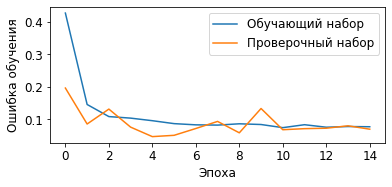

Acc =  0.6441873589164786


Epoch 1: 100%|██████████| 125/125 [00:28<00:00,  4.38it/s]


2023-05-26 20:42:10.207296 Epoch 1, Train loss 0.475, Val loss 0.487, Acc_val = 0.65


Epoch 2: 100%|██████████| 125/125 [00:28<00:00,  4.37it/s]


2023-05-26 20:42:39.784610 Epoch 2, Train loss 0.166, Val loss 0.695, Acc_val = 0.63


Epoch 3: 100%|██████████| 125/125 [00:28<00:00,  4.40it/s]


2023-05-26 20:43:09.122563 Epoch 3, Train loss 0.131, Val loss 0.974, Acc_val = 0.63


Epoch 4: 100%|██████████| 125/125 [00:28<00:00,  4.39it/s]


2023-05-26 20:43:38.515520 Epoch 4, Train loss 0.123, Val loss 1.171, Acc_val = 0.64


Epoch 5: 100%|██████████| 125/125 [00:28<00:00,  4.43it/s]


2023-05-26 20:44:07.673373 Epoch 5, Train loss 0.108, Val loss 1.089, Acc_val = 0.61


Epoch 6: 100%|██████████| 125/125 [00:28<00:00,  4.36it/s]


2023-05-26 20:44:37.287479 Epoch 6, Train loss 0.107, Val loss 1.045, Acc_val = 0.63


Epoch 7: 100%|██████████| 125/125 [00:29<00:00,  4.28it/s]


2023-05-26 20:45:07.437158 Epoch 7, Train loss 0.100, Val loss 1.433, Acc_val = 0.63


Epoch 8: 100%|██████████| 125/125 [00:32<00:00,  3.89it/s]


2023-05-26 20:45:40.493211 Epoch 8, Train loss 0.094, Val loss 1.115, Acc_val = 0.64


Epoch 9: 100%|██████████| 125/125 [00:32<00:00,  3.88it/s]


2023-05-26 20:46:13.674327 Epoch 9, Train loss 0.093, Val loss 1.549, Acc_val = 0.63


Epoch 10: 100%|██████████| 125/125 [00:33<00:00,  3.78it/s]


2023-05-26 20:46:47.856918 Epoch 10, Train loss 0.092, Val loss 1.428, Acc_val = 0.63


Epoch 11: 100%|██████████| 125/125 [00:40<00:00,  3.06it/s]


2023-05-26 20:47:31.511543 Epoch 11, Train loss 0.095, Val loss 1.360, Acc_val = 0.52


Epoch 12: 100%|██████████| 125/125 [00:51<00:00,  2.42it/s]


2023-05-26 20:48:26.697775 Epoch 12, Train loss 0.090, Val loss 1.460, Acc_val = 0.57


Epoch 13: 100%|██████████| 125/125 [00:48<00:00,  2.56it/s]


2023-05-26 20:49:18.839092 Epoch 13, Train loss 0.093, Val loss 1.271, Acc_val = 0.55


Epoch 14: 100%|██████████| 125/125 [00:59<00:00,  2.10it/s]


2023-05-26 20:50:21.956892 Epoch 14, Train loss 0.090, Val loss 1.496, Acc_val = 0.54


Epoch 15: 100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


2023-05-26 20:51:29.855907 Epoch 15, Train loss 0.087, Val loss 1.106, Acc_val = 0.53


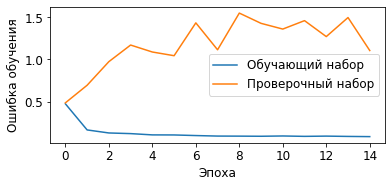

Acc =  0.6364087301587301
Final results
15 epoch. Acc_sk = 0.66 (Sens = 0.60 / Spec = 0.72) 0.56 / 0.78 / 0.71 / 0.64 / 0.64


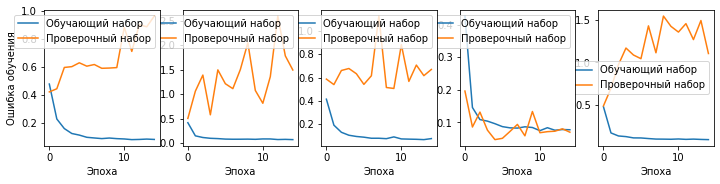

In [66]:
model_dir = 'model_backup'
if not os.path.exists(model_dir):  
  os.makedirs(model_dir)

DataSet_ALS = ALSDataset(dir_HC, dir_ALS)
model = ALS_CNN().to(device)
# model = time_CNN().to(device)

# one-layer conv->fc convs:(36,24,12)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-2) # good results (ACC = 0.64)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-2) # good results (60 epoch. ACC = 0.71 (Sens = 0.75 / Spec = 0.67))
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-3) # (100 epoch. ACC = 0.68 (Sens = 0.72 / Spec = 0.63))
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=2e-2) # (100 epoch. ACC = 0.69 (Sens = 0.73 / Spec = 0.65))
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-2) # (120 epoch. ACC = 0.68 (Sens = 0.72 / Spec = 0.65))

# optimizer = optim.Adam(model.parameters(),lr=1e-3, weight_decay=1e-1) # weight_decay is L2 regularization
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-2) #(30 epoch. ACC = 0.65 (Sens = 0.74 / Spec = 0.56))
# optimizer = optim.SGD(model.parameters(),lr=1e-3,momentum = 0.2, weight_decay=1e-2) #(30 epoch. ACC = 0.65 (Sens = 0.74 / Spec = 0.56))

# optimizer = optim.RMSprop(model.parameters(), lr=5e-3, weight_decay=1e-2) # (15 epoch. Acc = 0.52 (Sens = 0.48 / Spec = 0.56)) 0.559 / 0.552 / 0.518 / 0.423 / 0.580
# change xavier to kaming for conv layers
# optimizer = optim.RMSprop(model.parameters(), lr=5e-3, weight_decay=1e-2) # (15 epoch. Acc = 0.57 (Sens = 0.56 / Spec = 0.58)) 0.571 / 0.536 / 0.486 / 0.566 / 0.707
# optimizer = optim.Adadelta(model.parameters(), lr=1e-3,weight_decay=1e-2) # (15 epoch. Acc = 0.73 (Sens = 0.77 / Spec = 0.68)) 0.686 / 0.837 / 0.626 / 0.730 / 0.807 (good behaviour)
# l2_kernel_size = 5 (before value 7)
# optimizer = optim.Adadelta(model.parameters(), lr=1e-3,weight_decay=1e-2) # (15 epoch. Acc_sk = 0.71 (Sens = 0.73 / Spec = 0.70) 0.58 / 0.74 / 0.68 / 0.71 / 0.89 (good behaviour)
# l2_kernel_size = 9 (before value 7)
# optimizer = optim.Adadelta(model.parameters(), lr=1e-3,weight_decay=1e-2) # 15 epoch. Acc_sk = 0.67 (Sens = 0.73 / Spec = 0.61) 0.62 / 0.83 / 0.62 / 0.73 / 0.62
# optimizer = optim.Adadelta(model.parameters(), lr=1e-3,weight_decay=1e-1) # 15 epoch. Acc_sk = 0.66 (Sens = 0.72 / Spec = 0.60) 0.59 / 0.84 / 0.60 / 0.73 / 0.62
# l2_kernel_size = 7 (return to best) + layer2_filt = 32
# optimizer = optim.Adadelta(model.parameters(), lr=1e-3,weight_decay=1e-1) # 15 epoch. Acc_sk = 0.67 (Sens = 0.68 / Spec = 0.66) 0.61 / 0.74 / 0.63 / 0.67 / 0.69
# optimizer = optim.Adadelta(model.parameters(), lr=1e-3,weight_decay=1e-1) # 15 epoch. Acc_sk = 0.67 (Sens = 0.68 / Spec = 0.66) 0.61 / 0.74 / 0.63 / 0.67 / 0.69
optimizer = optim.Adam(model.parameters(), lr=1e-3,weight_decay=1e-1) # 15 epoch. Acc_sk = 0.66 (Sens = 0.60 / Spec = 0.72) 0.56 / 0.78 / 0.71 / 0.64 / 0.64

# timeCNN
# optimizer = optim.SGD(model.parameters(),lr=1e-3,momentum = 0.2, weight_decay=1e-2) #(30 epoch. ACC = 0.71 (Sens = 0.68 / Spec = 0.75))
# optimizer = optim.SGD(model.parameters(),lr=1e-3,momentum = 0.9, weight_decay=1e-2) #(30 epoch. ACC = 0.69 (Sens = 0.66 / Spec = 0.72))
# optimizer = optim.Adam(model.parameters(),lr=5e-3, weight_decay=1e-1) # #(20 epoch. Acc = 0.75 (Sens = 0.75 / Spec = 0.74))
# optimizer = optim.Adam(model.parameters(),lr=1e-2, weight_decay=2e-1) # #(20 epoch. Acc = 0.71 (Sens = 0.73 / Spec = 0.69))
# optimizer = optim.SGD(model.parameters(),lr=5e-3,momentum = 0.1, weight_decay=1e-1) #(20 epoch. ACC = 0.71 (Sens = 0.70 / Spec = 0.71))
# optimizer = optim.SGD(model.parameters(),lr=5e-3,momentum = 0.5, weight_decay=1e-1) #(20 epoch. ACC = 0.70 (Sens = 0.68 / Spec = 0.73))
# dropout = 0.6
# optimizer = optim.Adam(model.parameters(),lr=5e-3, weight_decay=1e-1) # (20 epoch. Acc = 0.73 (Sens = 0.69 / Spec = 0.77))
# dropout = 0.1
# optimizer = optim.Adam(model.parameters(),lr=5e-3, weight_decay=1e-1) # (20 epoch. Acc = 0.70 (Sens = 0.66 / Spec = 0.73))
# fc2 with 16 neurons
# optimizer = optim.Adam(model.parameters(),lr=5e-3, weight_decay=1e-1) # (20 epoch. Acc = 0.71 (Sens = 0.65 / Spec = 0.78))
# optimizer = optim.RMSprop(model.parameters(), lr=1e-1, weight_decay=1e-1) # (20 epoch. Acc = 0.54 (1-st fold))
# optimizer = optim.RMSprop(model.parameters(), lr=1e-3, weight_decay=1e-1) # (20 epoch. Acc = 0.63 (Sens = 0.51 / Spec = 0.75))
# tanh adter fc1 added
# optimizer = optim.RMSprop(model.parameters(), lr=5e-3, weight_decay=1e-1) # (15 epoch. Acc = 0.43 (Sens = 0.71 / Spec = 0.14))
# kaiming_normal_ changed
# optimizer = optim.RMSprop(model.parameters(), lr=5e-3, weight_decay=1e-2) # (15 epoch. Acc = 0.65 (Sens = 0.60 / Spec = 0.70)) 0.763 / 0.694 / 0.653 / 0.649 / 0.541
# dropout-1 = 0.05
# optimizer = optim.RMSprop(model.parameters(), lr=5e-3, weight_decay=1e-2) # (15 epoch. Acc = 0.55 (Sens = 0.56 / Spec = 0.54)) 0.502 / 0.426 / 0.712 / 0.621 / 0.557
# fc2 with 16 hidden unit deleted
# optimizer = optim.RMSprop(model.parameters(), lr=5e-3, weight_decay=1e-2) # 


k_fold_CV(dataset=DataSet_ALS, model = model, optimizer=optimizer, train = training_loop, n_epochs=15, k_fold=5)

In [ ]:
# Test 1
test_img = torch.rand(64,86)
test_img_row = test_img.view(-1,64*86)
print(test_img.shape)
print(test_img_row.shape)

# Test 2
test_img = torch.rand(1,10)
test_img_row = test_img.squeeze()
print(test_img.shape)
print(test_img_row.shape)

#Test 3
# print(torch.sigmoid(torch.tensor(-1)), torch.sigmoid(torch.tensor(0)), torch.sigmoid(torch.tensor(1)))

#Test 4
# x = torch.randn(3)
# x3 = torch.cat((x, x, x), 0)
# print(x3)

#Test 5
A = np.random.random((2,3))
print(A.shape)
A = A.reshape((1,A.shape[0],A.shape[1]))
print(A.shape)

torch.Size([64, 86])
torch.Size([1, 5504])
torch.Size([1, 10])
torch.Size([10])
(2, 3)
(1, 2, 3)


### CV-Fold selection

In [ ]:
file_name =  'HC_ALS_table.xlsx' # path to file + file name

xls_file = pd.ExcelFile(file_name)
# print(xls_file.sheet_names)

# https://stackoverflow.com/questions/17071871/how-do-i-select-rows-from-a-dataframe-based-on-column-values

df_HC = xls_file.parse('Control')
df_ALS = xls_file.parse('ALS')
# print(df_HC['fold']==1)
for fold_num in range(1,6):
    HC_fold = df_HC.loc[df_HC['fold']==fold_num]
    ALS_fold = df_ALS.loc[df_ALS['fold']==fold_num]
    # print(HC_fold)
    # print(ALS_fold)
    print(np.hstack((HC_fold['Subject code'].to_numpy(), ALS_fold['Subject code'].to_numpy())))
    HC_age = (float)(HC_fold.loc[:, 'Age'].mean())
    HC_m = (HC_fold.loc[HC_fold['Sex']=='m'])
    HC_f = (HC_fold.loc[HC_fold['Sex']=='f'])
    ALS_age = (float)(ALS_fold.loc[:, 'Age'].mean())
    ALS_m = (ALS_fold.loc[ALS_fold['Sex']=='m'])
    ALS_f = (ALS_fold.loc[ALS_fold['Sex']=='f'])
    print(f'Fold {fold_num} HC age mean = {HC_age:.2f}, mens = {len(HC_m.index)}, womens = {len(HC_f.index)}')
    print(f'Fold {fold_num} ALS age mean = {ALS_age:.2f}, mens = {len(ALS_m.index)}, womens = {len(ALS_f.index)}')

[ 26  97 117  85  53  86 127  92 102  27  32  72  39]
Fold 1 HC age mean = 52.43, mens = 3, womens = 4
Fold 1 ALS age mean = 56.83, mens = 3, womens = 3
[ 28 123  63  99  81 125 129  68  21  55  48  78  42]
Fold 2 HC age mean = 53.71, mens = 3, womens = 4
Fold 2 ALS age mean = 58.33, mens = 4, womens = 2
[ 61  16 115 109 111   2 107  46  84  64  52  24  76]
Fold 3 HC age mean = 55.43, mens = 2, womens = 5
Fold 3 ALS age mean = 59.67, mens = 4, womens = 2
[ 77   6  65  24 131 119  25  94  62  28   8  98  22]
Fold 4 HC age mean = 53.00, mens = 3, womens = 3
Fold 4 ALS age mean = 60.86, mens = 5, womens = 2
[ 49  89   4  42 113 121  96  20  58  80  31 100]
Fold 5 HC age mean = 54.17, mens = 2, womens = 4
Fold 5 ALS age mean = 61.00, mens = 4, womens = 2
